ranks:  [4.0, 1.0, 2.0, 3.0]
Pearson rank coefficient: 0.27
Spearman rank coefficient: 0.80


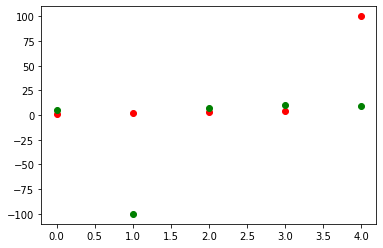

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

from tools import * 

config = pd.Series({
    'devide_by':5
})


l = [7, 1, 2, 5]
print("ranks: ", list2rank(l))

X = [1, 2, 3, 4, 100]
Y = [5, -100, 7, 10, 9]
plt.plot(X,'ro')
plt.plot(Y,'go')

print("Pearson rank coefficient: %.2f" % PearsonCorr(X, Y))
print("Spearman rank coefficient: %.2f" % spearmanRank(X, Y))

In [8]:
%%html
<style>
    p {
        float:left
    }  
    table {
        display: inline-block
    }
</style>

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)<p><td>
        <tr>
    <table>
<div>

# Read data 2019 marc

|  | info |
| -- | -- |
|  | The data for 2019 marc are from 2019-03-28 17:54:30 until 2019-03-31 21:53:56 |

## New data 2019 Marc 

### dades_2019_Marc_info

#### Preprocessing the data 

In [10]:
dades_2019_Marc_info = pd.read_csv('../dades/2019/BicingNou_ESTACIONS/2019_03_Marc_BicingNou_ESTACIONS_old.csv')

print(dades_2019_Marc_info.shape)

# change column to one hot enconding
dades_2019_Marc_info['is_charging_station'] = dades_2019_Marc_info.is_charging_station.astype(np.int)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info['status'].replace(to_replace=['CLOSED', 'IN_SERVICE'], value=[0, 1], inplace=True)

# will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_info = remove_duplicates_all(dades_2019_Marc_info.copy(), 'last_reported')

# convert timestamps of last_updated
dades_2019_Marc_info = convert_timestamp(dades_2019_Marc_info.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_info = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

# we don't have this column anywhere in the new dataset so it got removed
# dades_2019_Marc_info.drop('last_reported', axis=1, inplace=True)

print(dades_2019_Marc_info.shape)

(355467, 13)


  0%|          | 0/399 [00:00<?, ?it/s]

(349863, 13)


### dades_2019_Marc_us

#### Preprocessing the data 

In [11]:
dades_2019_Marc_us = pd.read_csv('../dades/2019/BicingNou_INFORMACIO/2019_03_Marc_BicingNou_INFORMACIO.csv')

print(dades_2019_Marc_us.shape)

# dades_2019_Marc_us[~(dades_2019_Marc_us.altitude == "0")] # 884 row  does not have 0 in the altitud column
cond = (~(dades_2019_Marc_us.altitude == "0") & (dades_2019_Marc_us.capacity == 1))
print(dades_2019_Marc_us[cond].shape) 
# 884 row does not have 0 in the altitud column
# capacity is filled with values 1 to fix this we need to shift the data 

# Fix data 
dades_2019_Marc_us.loc[cond, ['capacity']] = dades_2019_Marc_us[cond].post_code
dades_2019_Marc_us.loc[cond, ['post_code']] = dades_2019_Marc_us[cond].address
dades_2019_Marc_us.loc[cond, ['address']] = dades_2019_Marc_us[cond].altitude
dades_2019_Marc_us.loc[cond, ['altitude']] = '0'

# post code is wrong need fixing using long & lat. 
# can be fixed using post code data from old dataset after the merge
dades_2019_Marc_us['post_code'] = '08908'

dades_2019_Marc_us = convert_timestamp(dades_2019_Marc_us.copy(), ['last_updated'], sort=True, add=True)

# convert timestamps to multimple of 3
dades_2019_Marc_us = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_us.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_us.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

dades_2019_Marc_us['physical_configuration'].replace(to_replace=['BIKESTATION', 'ELECTRICBIKESTATION'], value=[0, 1], inplace=True)

# create mew column of last reported and last updated 
dades_2019_Marc_us['street_name'] = dades_2019_Marc_us.apply(
    lambda x: " ".join(re.findall("[a-zA-Z]+", x['name'])),
    axis=1
)

def lambda_fun(name):
    ret = 'nan'
    try:
        ret = re.findall("\d+$", name)[0]
    except:
        ret = 'nan'
        
    return ret

# create mew column of last reported and last updated 
dades_2019_Marc_us['street_number'] = dades_2019_Marc_us.apply(
    lambda x: lambda_fun(x['name']),
    axis=1
)

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_us.drop(['address', 'name'], axis=1, inplace=True)

print(dades_2019_Marc_us.shape)


(352674, 11)
(884, 11)
(352674, 11)


# merge data us with data info

In [12]:
merged_data = dades_2019_Marc_info.merge(
    dades_2019_Marc_us.copy(), 
    left_on=[
        'station_id',
        'last_updated'
    ], 
    right_on=[
        'station_id',
        'last_updated'
    ],
    how='left',
    suffixes=("_stat", "_us")
).copy()

merged_data.shape

(351050, 22)

In [13]:
merged_data[merged_data.last_reported.isna()].shape[0], merged_data.shape[0],(merged_data[merged_data.last_reported.isna()].shape[0]/merged_data.shape[0])*100

(0, 351050, 0.0)

In [14]:
merged_data.drop(
    ['ttl_us', 'ttl_stat', 'last_reported'],
    axis=1, 
    inplace=True
)

In [15]:
merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'is_charging_station', 
    'status',
    'last_updated'
]] = merged_data[[
    'num_bikes_available',
    'num_bikes_available_types.mechanical', 
    'num_bikes_available_types.ebike', 
    'num_docks_available', 
    'is_installed', 
    'is_renting', 
    'is_returning', 
    'is_charging_station', 
    'status', 
    'last_updated'
]].astype(np.int)

In [92]:
merged_data.post_code.fillna('08908', inplace=True)

merged_data.altitude = merged_data.altitude.fillna('0').astype(np.int)

merged_data.physical_configuration.fillna(1., inplace=True)

merged_data = correct_columns(merged_data, 'station_id', 'capacity')

merged_data = correct_columns(merged_data, 'station_id', 'lat')

merged_data = correct_columns(merged_data, 'station_id', 'lon')

merged_data = correct_columns(merged_data, 'station_id', 'street_name')

merged_data = correct_columns(merged_data, 'station_id', 'street_number')


In [93]:
merged_data.shape,merged_data.columns

((351050, 19),
 Index(['station_id', 'num_bikes_available',
        'num_bikes_available_types.mechanical',
        'num_bikes_available_types.ebike', 'num_docks_available',
        'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
        'status', 'last_updated', 'physical_configuration', 'altitude',
        'post_code', 'capacity', 'lat', 'lon', 'street_name', 'street_number'],
       dtype='object'))

# Old data 2019 Gener, Febrer, Marc 

In [94]:
dades_2019_Marc_info_old = pd.read_csv('../dades/2019/BICING_ESTACIONS/2019_03_Marc_BICING_ESTACIONS.csv')

print(dades_2019_Marc_info_old.shape)

dades_2019_Marc_info_old.rename(
    columns={
        'id': 'station_id',
        'latitude':'lat',
        'longitude':'lon',
        'type':'physical_configuration',
        'updateTime':'last_updated',
        'bikes':'num_bikes_available',
        'slots':'num_docks_available',
        'streetName':'street_name',
        'streetNumber':'street_number',
    }, 
    inplace=True
)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Marc_info_old['status'].replace(to_replace=['CLS', 'OPN'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['physical_configuration'].replace(to_replace=['BIKE', 'BIKE-ELECTRIC'], value=[0, 1], inplace=True)

dades_2019_Marc_info_old['is_installed'] = 1
dades_2019_Marc_info_old['is_renting'] = 1
dades_2019_Marc_info_old['is_returning'] = 1
dades_2019_Marc_info_old['is_charging_station'] = 1
dades_2019_Marc_info_old['num_bikes_available_types.mechanical'] = dades_2019_Marc_info_old['num_bikes_available']
dades_2019_Marc_info_old['num_bikes_available_types.ebike'] = 0
dades_2019_Marc_info_old['post_code'] = ''
dades_2019_Marc_info_old['capacity'] = 0

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Marc_info_old.drop('nearbyStations', axis=1, inplace=True)

dades_2019_Marc_info_old = convert_timestamp(dades_2019_Marc_info_old.copy(), ['last_updated'], sort=True, add=True, pattern='%d/%m/%y %H:%M:%S')

# convert timestamps to multimple of 3
dades_2019_Marc_info_old = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Marc_info_old.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Marc_info_old.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

print(dades_2019_Marc_info_old.shape)


/home/user/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3954821, 12)
(3954821, 19)


In [95]:
print_duplicates(dades_2019_Marc_info_old, ['station_id', 'last_updated'])

physical_configuration                  1
lat                                     1
lon                                     1
street_name                             1
street_number                           1
altitude                                1
num_docks_available                     1
num_bikes_available                     1
status                                  1
is_installed                            1
is_renting                              1
is_returning                            1
is_charging_station                     1
num_bikes_available_types.mechanical    1
num_bikes_available_types.ebike         1
post_code                               1
capacity                                1
dtype: int64

In [96]:
dades_2019_Marc_info_old.columns

Index(['station_id', 'physical_configuration', 'lat', 'lon', 'street_name',
       'street_number', 'altitude', 'num_docks_available',
       'num_bikes_available', 'status', 'last_updated', 'is_installed',
       'is_renting', 'is_returning', 'is_charging_station',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'post_code', 'capacity'],
      dtype='object')

# Merge data Marc old with new

In [97]:
dades_2019_Marc_info_old.columns

Index(['station_id', 'physical_configuration', 'lat', 'lon', 'street_name',
       'street_number', 'altitude', 'num_docks_available',
       'num_bikes_available', 'status', 'last_updated', 'is_installed',
       'is_renting', 'is_returning', 'is_charging_station',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'post_code', 'capacity'],
      dtype='object')

In [98]:
merged_data.columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'is_charging_station',
       'status', 'last_updated', 'physical_configuration', 'altitude',
       'post_code', 'capacity', 'lat', 'lon', 'street_name', 'street_number'],
      dtype='object')

In [99]:
%%time

dades_2019_Marc_tot = pd.concat([merged_data,dades_2019_Marc_info_old])

CPU times: user 232 ms, sys: 150 ms, total: 382 ms
Wall time: 380 ms


In [100]:
dades_2019_Marc_tot.reset_index(drop = True)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,is_charging_station,status,last_updated,physical_configuration,altitude,post_code,capacity,lat,lon,street_name,street_number
0,1,16,16,0,14,1,1,1,1,1,1553795700,1.0,0,08908,30.0,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760
1,41,13,13,0,7,1,1,1,1,1,1553795700,1.0,0,08908,21.0,41.379326,2.189906,PL POETA BOSC ATL NTIDA,nan
2,327,0,0,0,24,1,1,1,1,1,1553795700,1.0,0,08908,24.0,41.405000,2.134530,C REUS,23
3,326,0,0,0,32,1,1,1,1,1,1553795700,1.0,0,08908,32.0,41.407384,2.138300,C BALMES,409
4,42,8,8,0,14,1,1,1,1,1,1553795700,1.0,0,08908,24.0,41.404511,2.189881,C CIUTAT DE GRANADA AV DIAGONAL,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305866,136,22,22,0,4,1,1,1,1,0,1554076200,0.0,9,,0.0,41.414226,2.201734,Gran Vía,1062
4305867,135,0,0,0,21,1,1,1,1,0,1554076200,0.0,13,,0.0,41.411908,2.197936,Gran Vía,981
4305868,134,0,0,0,20,1,1,1,1,0,1554076200,0.0,10,,0.0,41.411433,2.198735,Bac de Roda,157
4305869,105,0,0,0,18,1,1,1,1,0,1554076200,0.0,32,,0.0,41.389197,2.173555,PL. Urquinaona,9


In [101]:
dades_2019_Marc_tot.shape

(4305871, 19)

In [102]:
# replace nans with string of 0
dades_2019_Marc_tot.street_number = dades_2019_Marc_tot.street_number.astype(str)
dades_2019_Marc_tot.street_number.fillna('0', inplace=True)
dades_2019_Marc_tot.loc[dades_2019_Marc_tot.street_number.isin(['nan', '.']),['street_number']] = '0' 

# extract the correct column
correct_column = dades_2019_Marc_tot[dades_2019_Marc_tot.street_number != '0'].groupby(['station_id'])['street_number'].max()
correct_column = pd.DataFrame(correct_column.reset_index())
# correct the data according to the data in the correct column
dades_2019_Marc_tot = correct_columns(dades_2019_Marc_tot.copy(), 'station_id', 'street_number', correct_column=correct_column)

dades_2019_Marc_tot.street_number.fillna('0', inplace=True)

dades_2019_Marc_tot = correct_columns(dades_2019_Marc_tot.copy(), 'station_id', 'capacity')

dades_2019_Marc_tot.loc[dades_2019_Marc_tot.capacity.isna(),['capacity']] = 0

dades_2019_Marc_tot = correct_columns(dades_2019_Marc_tot.copy(), 'station_id', 'altitude')

cond = (dades_2019_Marc_tot.num_bikes_available + dades_2019_Marc_tot.num_docks_available) > dades_2019_Marc_tot.capacity
dades_2019_Marc_tot.loc[cond, ['capacity']] = dades_2019_Marc_tot[cond]['num_bikes_available'] + dades_2019_Marc_tot[cond]['num_docks_available']

In [103]:
# check again for nans
get_features_nans(dades_2019_Marc_tot)

{}

In [104]:
get_features_zero(dades_2019_Marc_tot)

{'num_bikes_available': 72.81265509347587,
 'num_bikes_available_types.mechanical': 72.81265509347587,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 2.337970645195827,
 'status': 76.64804635345554,
 'physical_configuration': 83.2767168361523,
 'capacity': 0.36355013886853554,
 'altitude': 3.4442044362220794}

### Study on TTL for station 1
Taking one station ID and looking for the best TTL for multiple answers from the same time


In [105]:
dades_2019_Marc_tot_s1 = dades_2019_Marc_tot[dades_2019_Marc_tot.station_id == 1]

In [106]:
dades_2019_Marc_tot_s1.shape

(9430, 19)

In [107]:
get_features_nans(dades_2019_Marc_tot_s1)

{}

In [108]:
get_features_zero(dades_2019_Marc_tot_s1)

{'num_bikes_available': 90.63626723223754,
 'num_bikes_available_types.mechanical': 90.63626723223754,
 'num_bikes_available_types.ebike': 100.0,
 'num_docks_available': 2.757158006362672,
 'status': 90.59384941675503,
 'physical_configuration': 90.59384941675503}

In [109]:
get_columns(dades_2019_Marc_tot_s1)

{'station_id': 1,
 'num_bikes_available': 29,
 'num_bikes_available_types.mechanical': 29,
 'num_bikes_available_types.ebike': 1,
 'num_docks_available': 28,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'is_charging_station': 1,
 'status': 2,
 'last_updated': 8555,
 'physical_configuration': 2,
 'post_code': 2,
 'lat': 1,
 'lon': 1,
 'street_name': 2,
 'street_number': 1,
 'capacity': 1,
 'altitude': 1}

In [110]:
dades_2019_Marc_tot_s1.street_name.unique()

array(['C GRAN VIA CORTS CATALANES', 'Gran Via Corts Catalanes'],
      dtype=object)

In [111]:
dades_2019_Marc_tot_s1.post_code.unique()

array(['08908', ''], dtype=object)

In [112]:
dades_2019_Marc_tot_s1.head(5)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,is_charging_station,status,last_updated,physical_configuration,post_code,lat,lon,street_name,street_number,capacity,altitude
0,1,16,16,0,14,1,1,1,1,1,1553795700,1.0,08908,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760,30.0,21
780,1,18,18,0,12,1,1,1,1,1,1553796600,1.0,08908,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760,30.0,21
1166,1,18,18,0,12,1,1,1,1,1,1553796900,1.0,08908,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760,30.0,21
1260,1,19,19,0,11,1,1,1,1,1,1553797200,1.0,08908,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760,30.0,21
1816,1,18,18,0,12,1,1,1,1,1,1553797500,1.0,08908,41.397952,2.180042,C GRAN VIA CORTS CATALANES,760,30.0,21


### last_updated 

|  | info |
| -- | -- |
|  | last updates is the timestamp for the file |
|  | a station id will never have repeated last_updated timestamp in the dataset |

In [113]:
(dades_2019_Marc_tot_s1.last_updated.value_counts() > 1).any()  # give insight if there any last_updated timestamps is repeated 

True

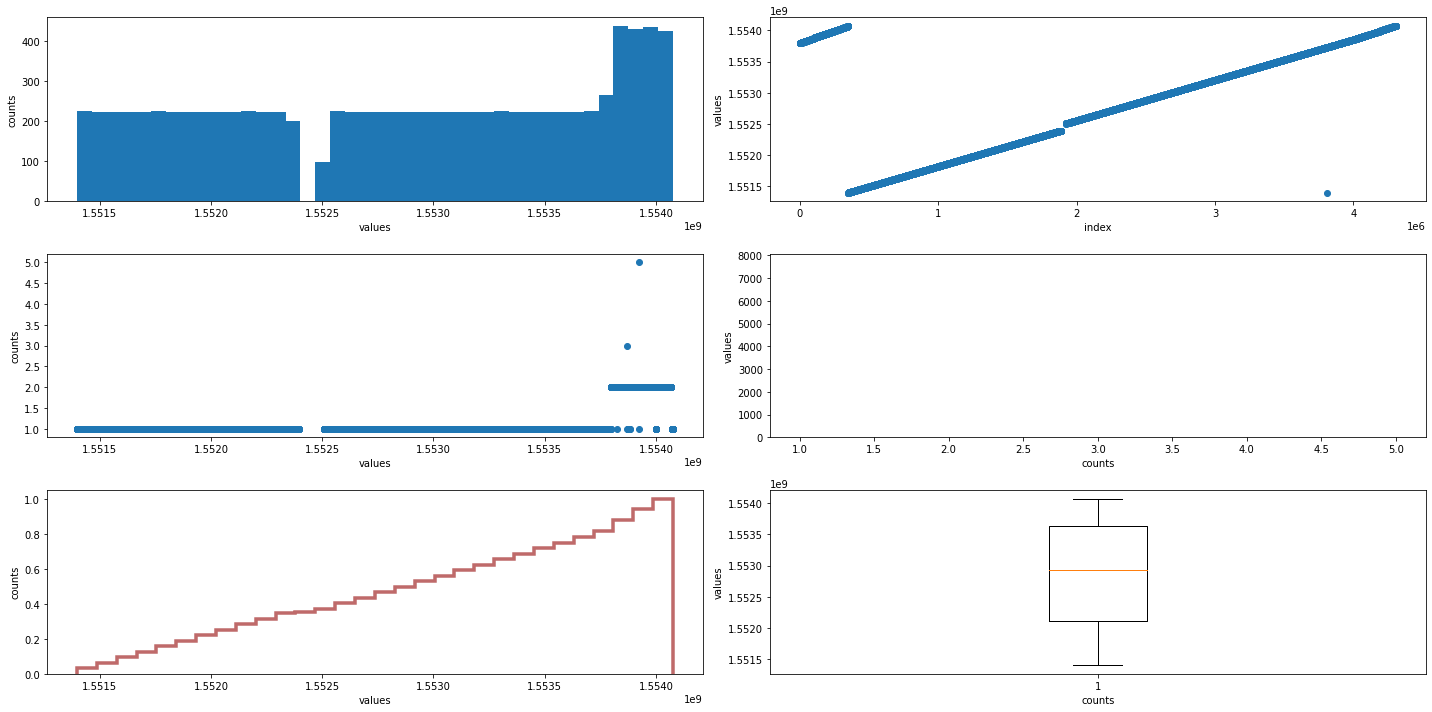

In [114]:
show_column_counts(dades_2019_Marc_tot_s1, 'last_updated')

## study finished

## station_id

In [115]:
print(stats.describe(dades_2019_Marc_tot.station_id))
dades_2019_Marc_tot.station_id.describe()

DescribeResult(nobs=4305871, minmax=(1, 496), mean=235.5680279320955, variance=18963.95824561403, skewness=0.09424896880768865, kurtosis=-1.080197568938587)


count    4.305871e+06
mean     2.355680e+02
std      1.377097e+02
min      1.000000e+00
25%      1.180000e+02
50%      2.330000e+02
75%      3.470000e+02
max      4.960000e+02
Name: station_id, dtype: float64

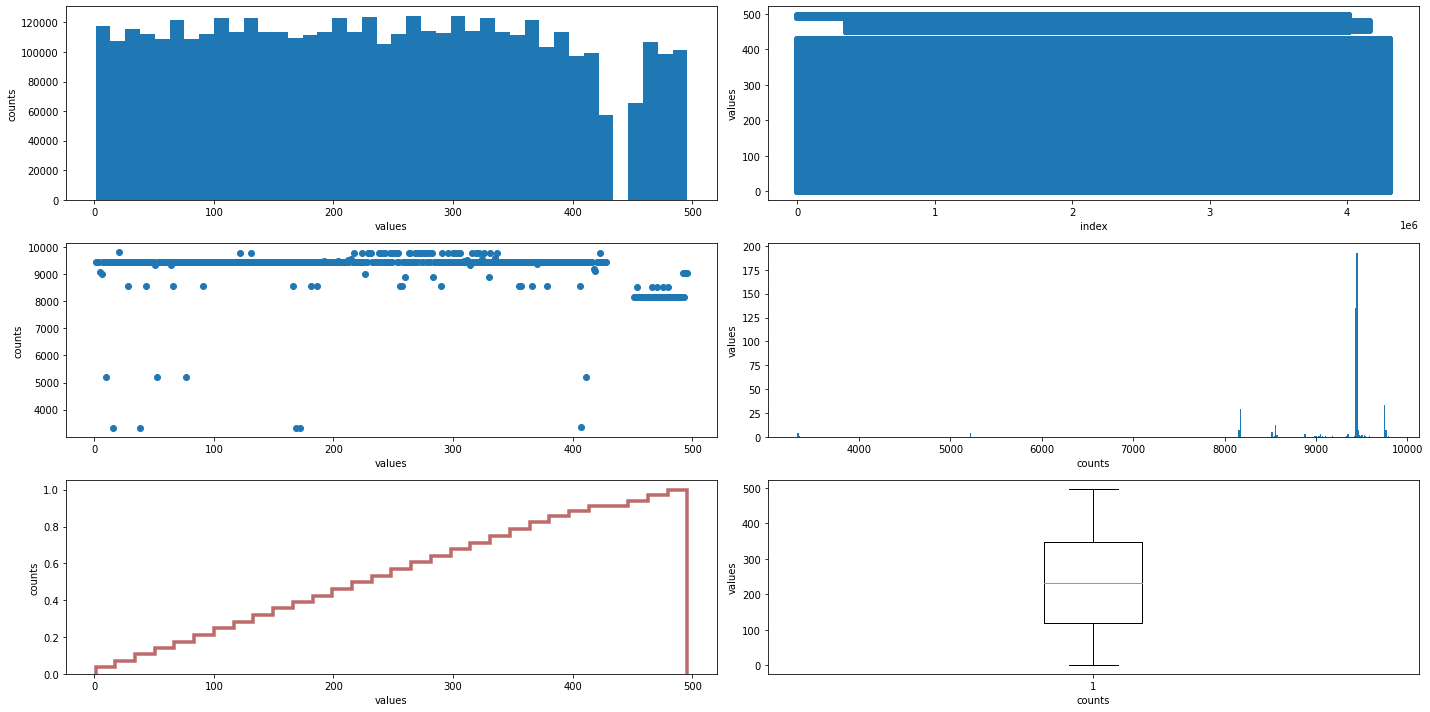

In [116]:
# station_id 
# Most values are repeated equally in the dataset
show_column_counts(dades_2019_Marc_tot, 'station_id')

## num_bikes_available

In [117]:
# num_bikes_available
# by looking at the differance between the 75% and max number 
# existance of outliers is possible. 54 is too big for a station size
# TODO, check max size of a station? Replace outliers with the maximum size
print(stats.describe(dades_2019_Marc_tot.num_bikes_available))
dades_2019_Marc_tot.num_bikes_available.describe()

DescribeResult(nobs=4305871, minmax=(0, 54), mean=2.881951410063144, variance=41.78936420877502, skewness=2.5975587391806525, kurtosis=6.634641980654209)


count    4.305871e+06
mean     2.881951e+00
std      6.464469e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.400000e+01
Name: num_bikes_available, dtype: float64

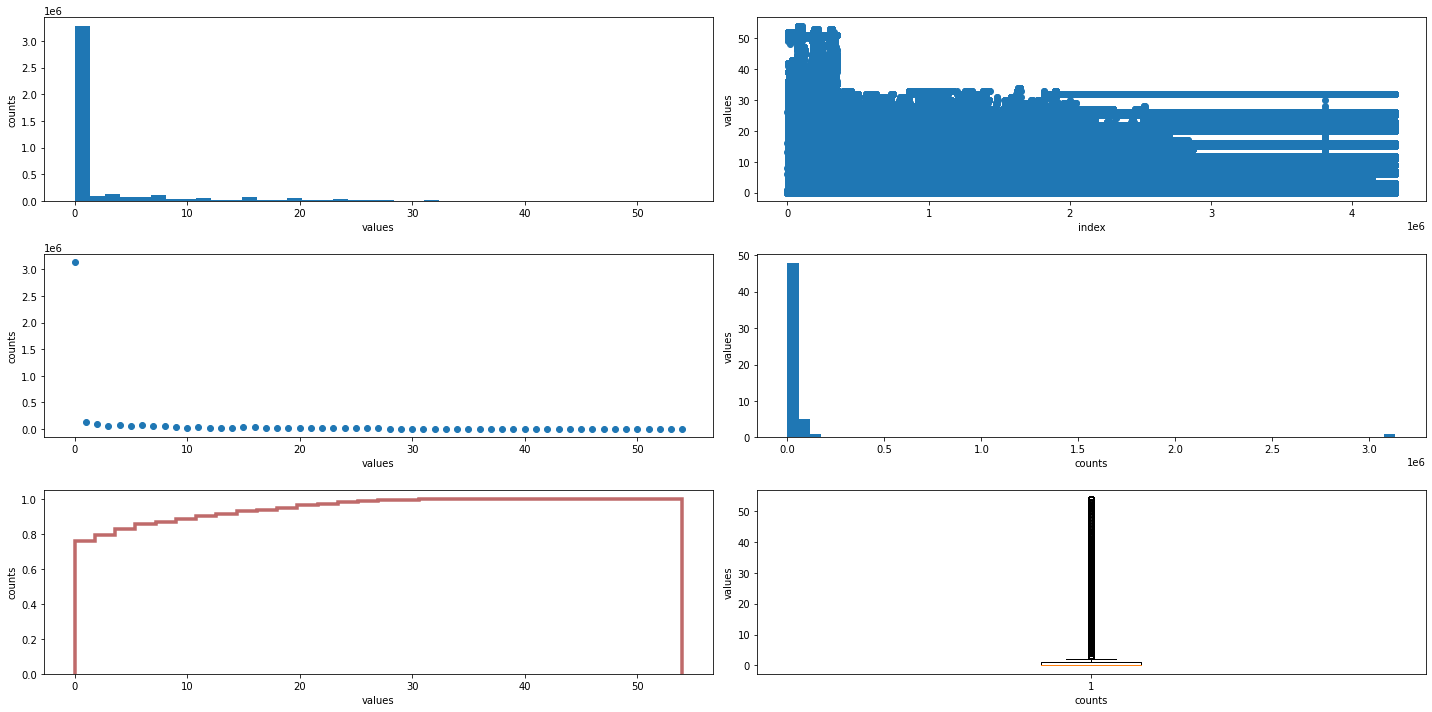

In [118]:
show_column_counts(dades_2019_Marc_tot, 'num_bikes_available')

## num_docks_available

In [119]:
print(stats.describe(dades_2019_Marc_tot.num_docks_available))
dades_2019_Marc_tot.num_docks_available.describe()

DescribeResult(nobs=4305871, minmax=(0, 54), mean=21.432002491481978, variance=75.74091527646604, skewness=-0.9227206079031215, kurtosis=0.08759616706663609)


count    4.305871e+06
mean     2.143200e+01
std      8.702926e+00
min      0.000000e+00
25%      1.800000e+01
50%      2.400000e+01
75%      2.700000e+01
max      5.400000e+01
Name: num_docks_available, dtype: float64

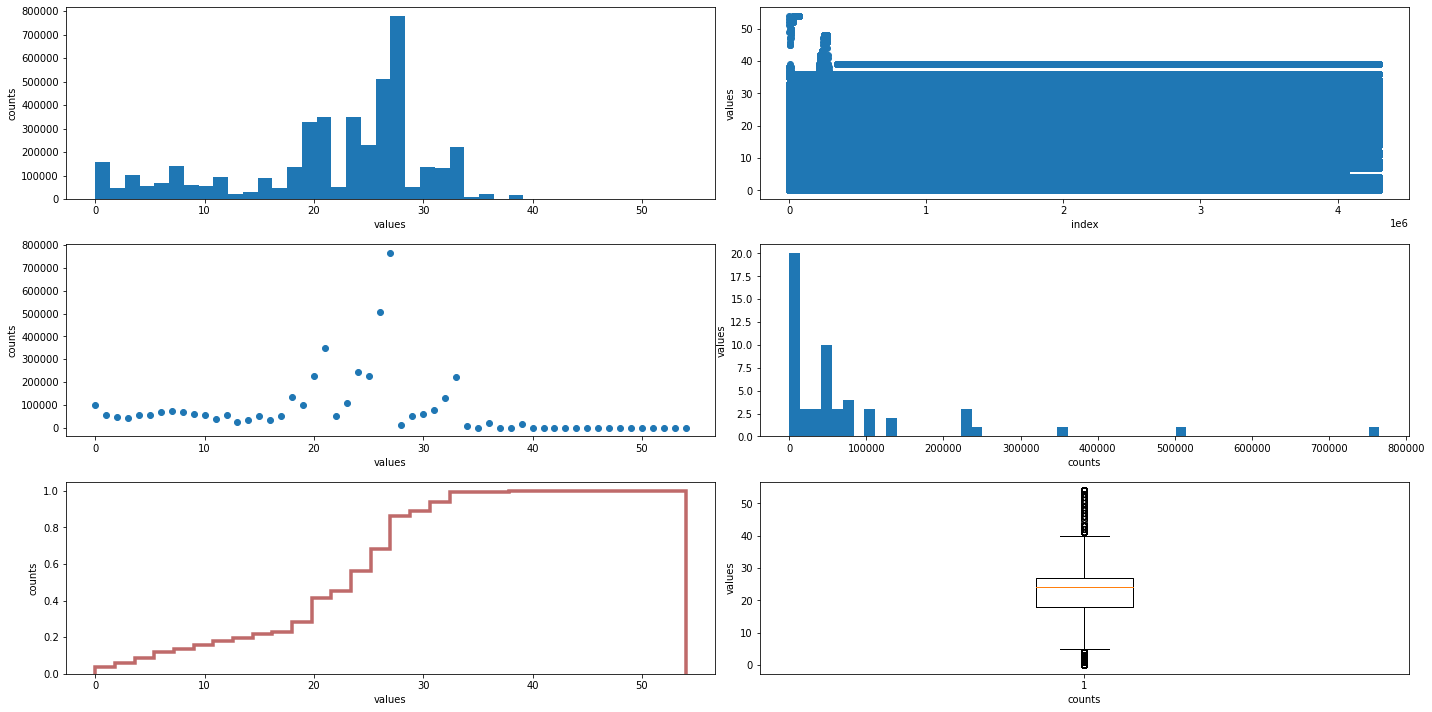

In [120]:
show_column_counts(dades_2019_Marc_tot, 'num_docks_available')

## capacity

In [121]:
print(stats.describe(dades_2019_Marc_tot.capacity))
dades_2019_Marc_tot.capacity.describe()

DescribeResult(nobs=4305871, minmax=(0.0, 54.0), mean=25.54936829273334, variance=46.459249201491104, skewness=-0.023900109869524445, kurtosis=3.400762169311111)


count    4.305871e+06
mean     2.554937e+01
std      6.816102e+00
min      0.000000e+00
25%      2.100000e+01
50%      2.700000e+01
75%      2.700000e+01
max      5.400000e+01
Name: capacity, dtype: float64

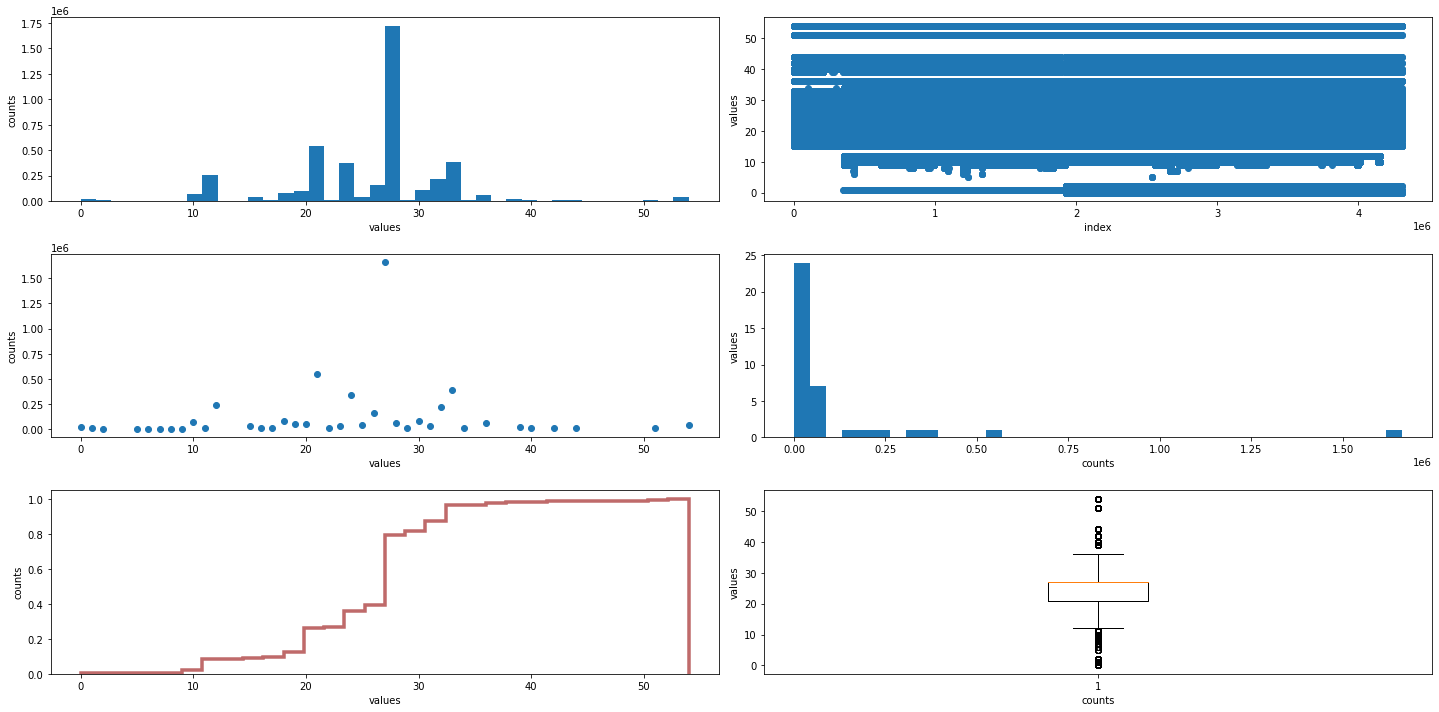

In [122]:
show_column_counts(dades_2019_Marc_tot, 'capacity')

## Cleaning and store of new file

In [123]:
print_duplicates(dades_2019_Marc_tot, ['station_id', 'last_updated'])

num_bikes_available                     3
num_bikes_available_types.mechanical    3
num_bikes_available_types.ebike         1
num_docks_available                     3
is_installed                            1
is_renting                              1
is_returning                            1
is_charging_station                     1
status                                  2
physical_configuration                  2
post_code                               2
lat                                     2
lon                                     2
street_name                             2
street_number                           1
capacity                                2
altitude                                1
dtype: int64

In [124]:
dades_2019_Marc_tot['ttl'] = 30.

In [125]:
### will remove the duplicate for last reported for all stations in the dataset
dades_2019_Marc_tot = remove_duplicates_all(dades_2019_Marc_tot.copy(), 'last_updated')
# (4305871, 19)

  0%|          | 0/467 [00:00<?, ?it/s]

In [126]:
dades_2019_Marc_tot.shape

(3962162, 20)

In [127]:
f'{3979843-3962162} deleted'

'17681 deleted'

In [128]:
dades_2019_Marc_tot.to_csv('../dades/2019/BicingNou_ESTACIONS/2019_03_Marc_BicingNou_ESTACIONS.csv')

# Study of station id 1 year 2019 complete